## **Nombre**

Victor Alonso Marques.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt

## 1. Visualize the datasets

Plot the dust deposition rate of the empirical dataset in the measurement locations and the simulated data on the global grid.

In [2]:
df_empirical_Holocene = pd.read_csv("df_empirical_Holocene.csv")
df_empirical_LGM = pd.read_csv("df_empirical_LGM.csv")

In [3]:
world_map = gpd.read_file(geodatasets.get_path('naturalearth.land'))

In [4]:
def plot_dust_deposition_map(df, title, name_to_save, label_str='log_dep', measure_units='Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]', limit_bar = 3.2):
    """Generate a map plot of dust deposition based on the provided dataframe.

    Parameters:
    - df (pandas DataFrame): The dataframe containing the dust deposition data.
    - title(str): The title to be displayed on the plot.
    - name_to_save (str): The filename to save the generated map plot.
    - label_str (str, optional): The column name in the dataframe to use for labeling the data on the plot. Defaults to 'log_dep'.
    - measure_units (str, optional): The units of measurement for the dust flux. Defaults to 'Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]'.
    - limit_bar (float, optional): The limit value for the colorbar on the plot. Defaults to 3.2."""

    df_dust_geopandas = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

    fig, ax = plt.subplots(figsize=(12, 10))

    # Set limits and ticks
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    ax.set_xticks(np.arange(-180, 181, 45))
    ax.set_yticks(np.arange(-90, 91, 30))

    # Plot world map
    world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)

    # Plot the GeoDataFrame
    df_dust_geopandas.plot(column=label_str,
                           ax=ax,
                           legend=True,
                           legend_kwds={'label': measure_units, 'orientation': "horizontal"},
                           cmap='viridis',
                           vmin=-limit_bar,
                           vmax=limit_bar,
                           linewidth=0.005,
                           markersize=100)

    # Set labels and title
    ax.set(xlabel='Longitude', ylabel='Latitude', title=title)

    # Save and show the plot
    plt.savefig(f"{name_to_save}.pdf", bbox_inches='tight', dpi=600)
    plt.show()

    return


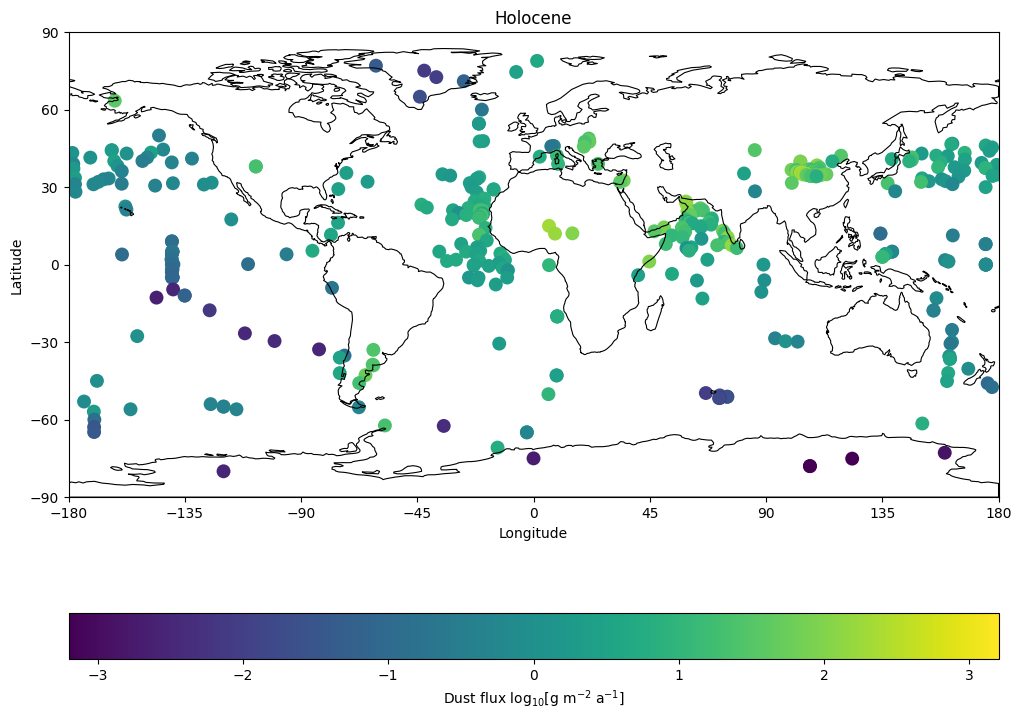

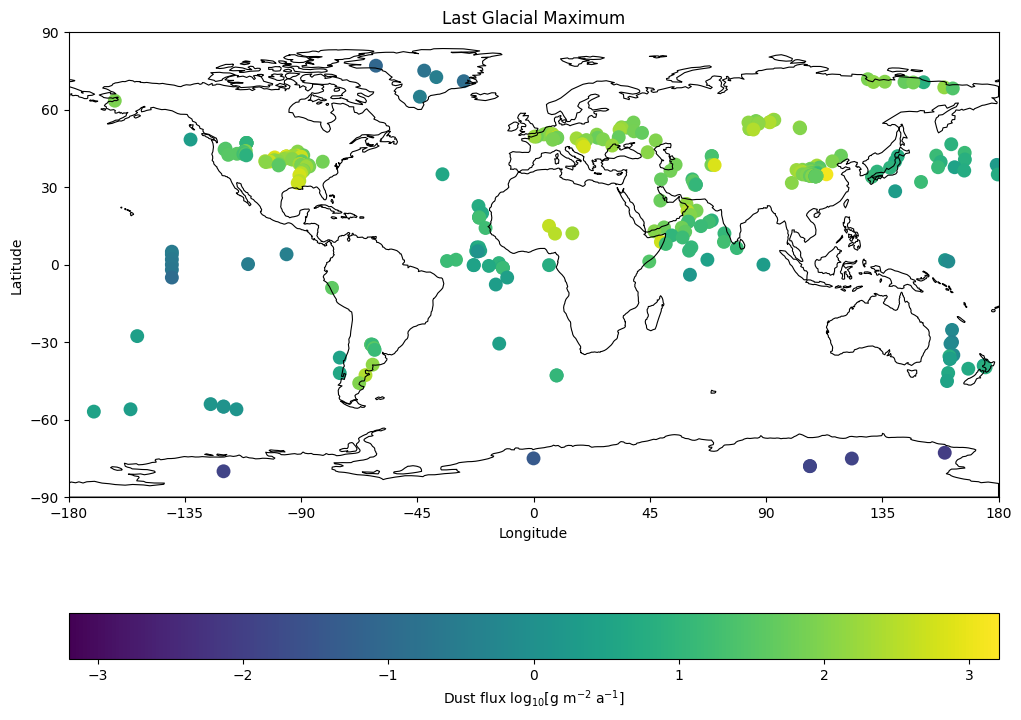

In [5]:
plot_dust_deposition_map(df=df_empirical_Holocene,
                         title='Holocene',
                         name_to_save='DATA_MAP_HOLOCENE')

plot_dust_deposition_map(df=df_empirical_LGM,
                         title='Last Glacial Maximum',
                         name_to_save='DATA_MAP_LGM')

## Create and visualize the global grid

The global grid for the predictions consists of 3-degree spacing.

In [6]:
longitude_to_predict = np.linspace(-180, 180, 121)
latitude_to_predict = np.linspace(-90, 90, 61)

xx, yy = np.meshgrid(longitude_to_predict, latitude_to_predict)
XYpairs = np.vstack([ xx.reshape(-1), yy.reshape(-1) ])
df_gpd_global_grid = gpd.GeoDataFrame(geometry=gpd.points_from_xy(XYpairs[0], XYpairs[1]))
df_global_grid = pd.DataFrame({
    'lon': df_gpd_global_grid.geometry.x,
    'lat': df_gpd_global_grid.geometry.y
})

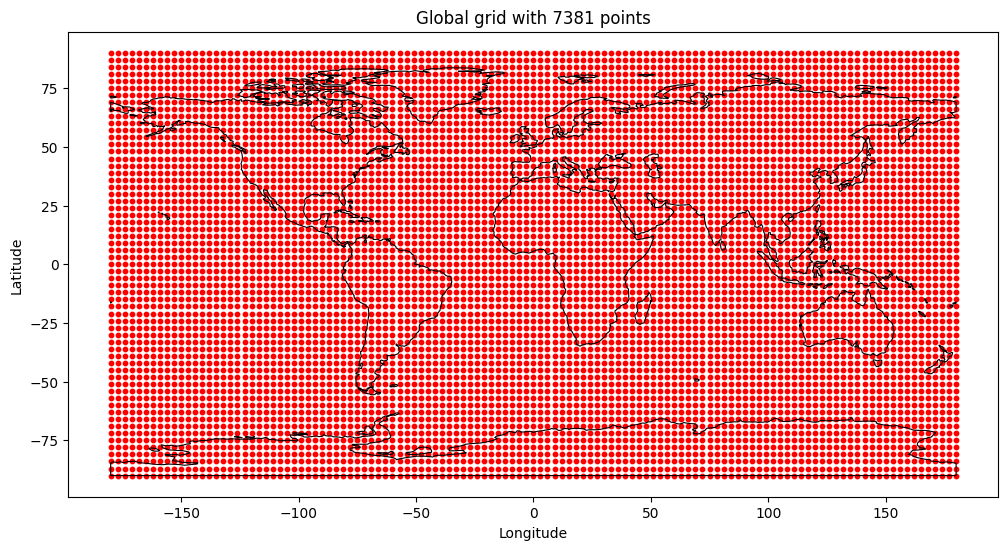

In [7]:
fig, ax = plt.subplots(figsize=(12,10))
world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)
df_gpd_global_grid.plot(ax=ax, color='red', markersize=10, marker ='o')

ax.set(xlabel='Longitude', ylabel='Latitude',
       title=f'Global grid with {df_gpd_global_grid.shape[0]} points')
plt.show()

## Analyse global deposition rate with nearest neighbours

The dust deposition rate will be estimated by averaging the values of the $k$ nearest neigbours.

In [8]:
def distance_euclidean(x, y):
    """
    Calculate the Euclidean distance between two points.

    Parameters:
    x,y : Iterable
        Vectors for the 2D location of the two points.
    """
    distance = np.sqrt( (x[0] - y[0])**2 + (x[1] - y[1])**2)
    return distance

## 2, 3: Hacer la geodesica

In [16]:
from math import acos, cos, sin, pi
def geodesic_simple(latitud_1, latitud_2, longitud_1, longitud_2, radio):
    return radio * acos(
        (sin(latitud_1)*sin(latitud_2)) +
        (cos(latitud_1)*cos(latitud_2)*cos(longitud_2 -longitud_1))
    )

def degree_to_radian(degrees):
    # 1 grado es pi/180
    # 180 grados es pi
    return degrees*pi/180

In [17]:
# Asumiendo una esfera de radio 1.
# En ese caso la latitud puede ir de -pi/2 a pi/2, pues hay 360 grados de longitud por el ecuador.
# pero la longitud puede ser de -pi a pi, es el doble.

print("Mismo punto. Deberia ser 0:", geodesic_simple(pi/2, pi/2, 0, 0, 1))
print("Polos norte a sur. Deberia ser pi:", geodesic_simple(pi/2, -pi/2, 0, 0, 1))

print("Mismo punto, distinta representacion. Deberia ser 0:", geodesic_simple(0, 0, pi, -pi, 1))
print("Greenwich hasta el extremo. Deberia ser pi:", geodesic_simple(0, 0, pi, 0, 1))

print("Ecuador a Polo norte. deberia ser pi/2:", geodesic_simple(0, pi/2, 0, 0, 1))

print("Esquinas. deberia ser pi:", geodesic_simple(pi/2, -pi/2, pi, -pi, 1))

# Verificar funcion en la tierra

# Sitio de verificacion de funcion:
# https://www.distance.to/Santiago,Metropolitana-de-Santiago,CHL/Madrid,Comunidad-de-Madrid,ESP

santiago = [degree_to_radian(-33.437797),degree_to_radian(-70.650445)] # latitud, longitud
madrid = [degree_to_radian(40.416705),degree_to_radian(-3.703582)] # latitud, longitud
radio_tierra = 6371.009 # Radio de la tierra segun wikipedia

print("distancia Santiago, Madrid. deberia ser 10,699.98 km:", geodesic_simple(santiago[0], madrid[0], santiago[1], madrid[1], radio_tierra))

Mismo punto. Deberia ser 0: 0.0
Polos norte a sur. Deberia ser pi: 3.141592653589793
Mismo punto, distinta representacion. Deberia ser 0: 0.0
Greenwich hasta el extremo. Deberia ser pi: 3.141592653589793
Ecuador a Polo norte. deberia ser pi/2: 1.5707963267948966
Esquinas. deberia ser pi: 3.141592653589793
distancia Santiago, Madrid. deberia ser 10,699.98 km: 10699.980599258084


In [18]:
def distance_geodesic(x, y):
    """
    Calculate the geodesic distance between two points on Earth.

    Parameters:
    x,y : Iterable
        Vectors for the 2D location of the two points.
    """
    # distance = geodatasets.geodesic_distance(x[0], x[1], y[0], y[1])
    # lol, eso seria muy facil, me lo dio copilot.
    phi_1 = degree_to_radian(x[0])
    phi_2 = degree_to_radian(y[0])
    lambda_1 = degree_to_radian(x[1])
    lambda_2 = degree_to_radian(y[1])
    radius = 6371.009
    return geodesic_simple(phi_1, phi_2, lambda_1, lambda_2, radius)

In [19]:
def nearest_neighbour_estimation(df, x, k, dist):
    """
    Perform a k nearest neighbour estimation.

    Parameters:
    df : pandas.DataFrame
        The database.
    x : Iterable
        Location for the estimation.
    k : int
        The number of neighbours to consider.
    dist : str
        The type of distance definition.
    """
    
    if dist == "geodesic": # Comentario añadido: esto no es pitonico ARGHHHH, deberian especificar
                           # distance_fun como variable de funcion ARGGGGG!!! VARIABLES GLOBALES GRHHH
        distance_fun = distance_geodesic
    else:
        distance_fun = distance_euclidean
    
    distances = np.repeat(np.inf, len(df))
    for index, row in df.iterrows():
        distances[index] = distance_fun(x, (row["lon"], row["lat"]))
    
    sorted_indices = np.argsort(distances)
    nearest_points = sorted_indices[:k]
    
    values_neighbours = df.loc[nearest_points, "log_dep"]
    estimation = np.average(values_neighbours)
    
    return estimation

## 4 Visualizacion de resultados

In [20]:
# Choose the number of neighbours to include in the estimation
n_neighbours = 5

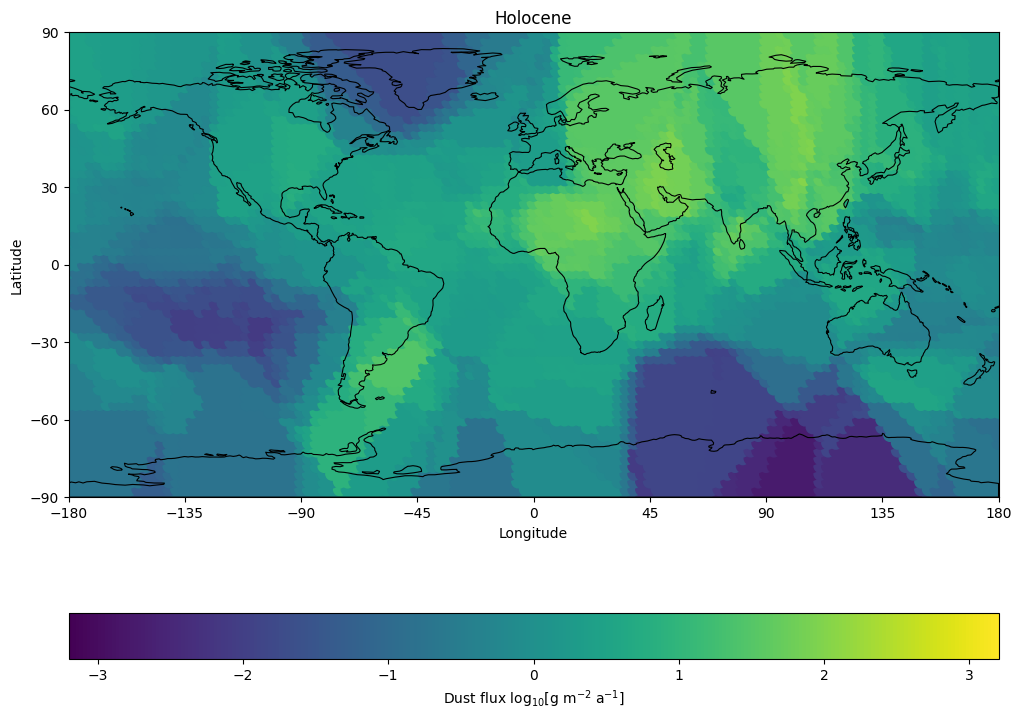

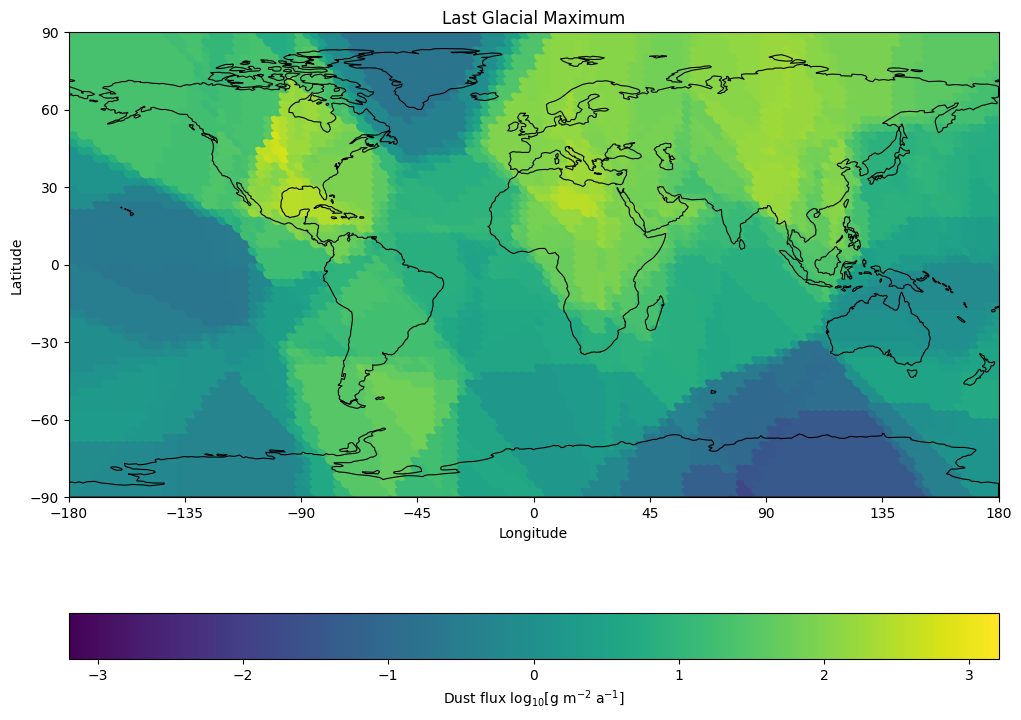

In [21]:
estimations_holocene_euclid = np.repeat(np.inf, len(df_global_grid))
estimations_lgm_euclid = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene_euclid[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='euclidean')
    estimations_lgm_euclid[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='euclidean')

df_global_grid["est_hol_euclid"] = estimations_holocene_euclid
df_global_grid["est_lgm_euclid"] = estimations_lgm_euclid

del estimations_holocene_euclid
del estimations_lgm_euclid


plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE',
                         label_str='est_hol_euclid')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM',
                         label_str='est_lgm_euclid')

**Estos resultado representan la distancia euclideana**

Ahora toca hacer lo mismo con distancia geodesica.

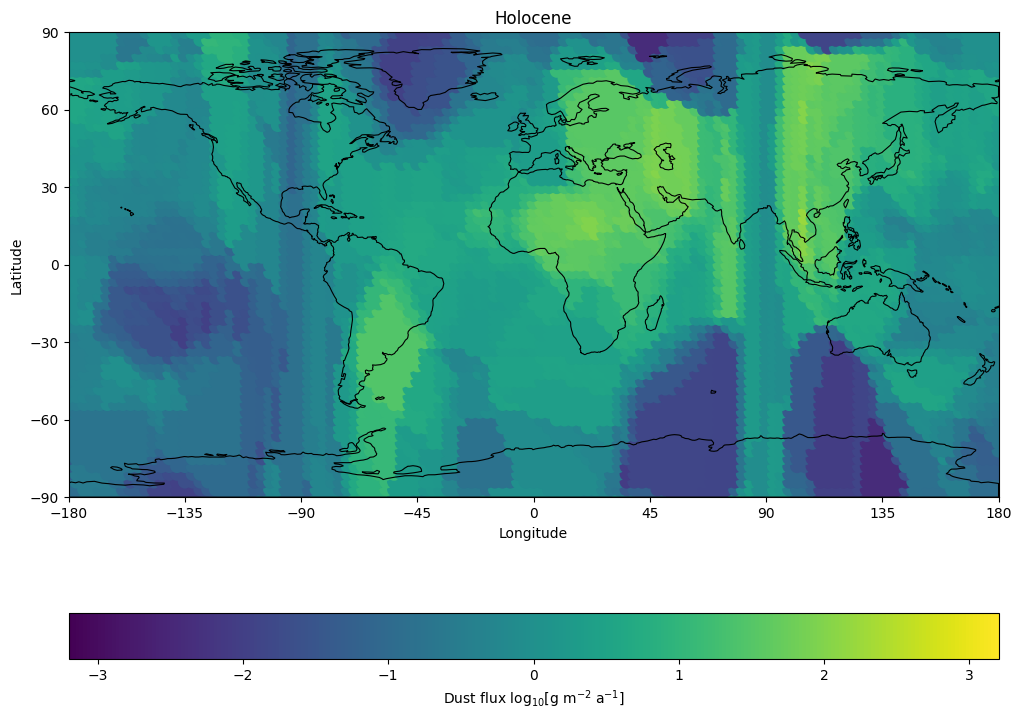

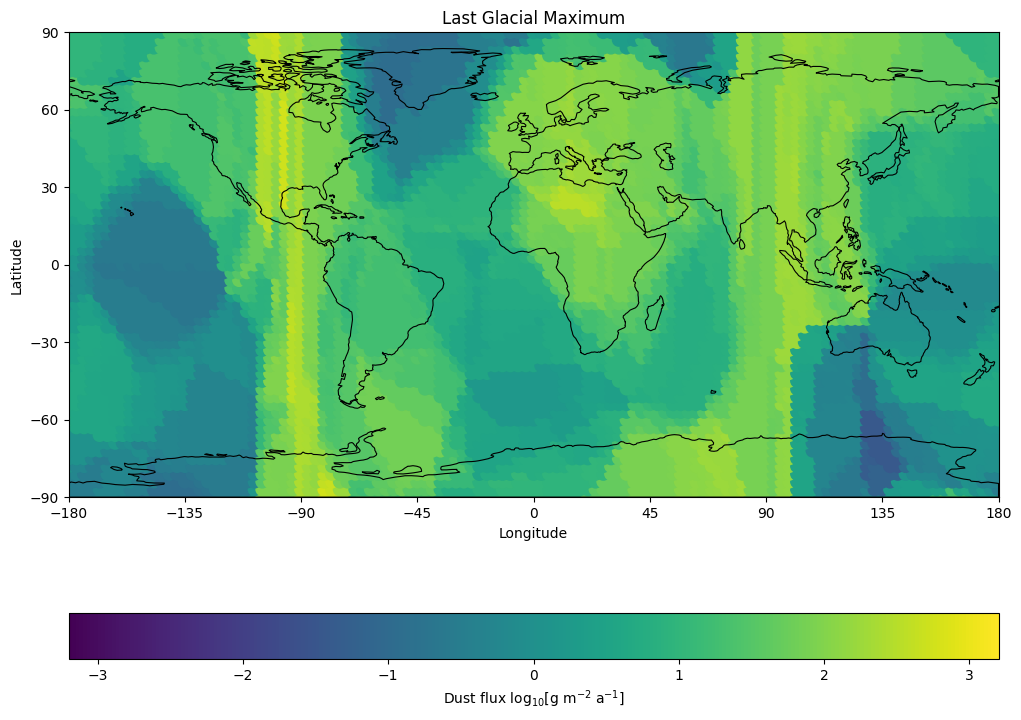

In [22]:
estimations_holocene_geo_mala = np.repeat(np.inf, len(df_global_grid))
estimations_lgm_geo_mala = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene_geo_mala[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='geodesic')
    estimations_lgm_geo_mala[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='geodesic')

df_global_grid["est_hol_geo_mala"] = estimations_holocene_geo_mala
df_global_grid["est_lgm_geo_mala"] = estimations_lgm_geo_mala

del estimations_holocene_geo_mala
del estimations_lgm_geo_mala


plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE',
                         label_str='est_hol_geo_mala')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM',
                         label_str='est_lgm_geo_mala')

**El mapa esta mal, eso es obvio**

Ahora bien, cuando vi este mapa por primera vez supe inmediatamente que habia algo mal, esas lineas verticales no son caracteristicas de un mapa de distancia mas cercana geodesica, asi que lo que sospeche inmediatamente fue que el algoritmo usa primero la longitud y despues la latitud, en vez de al revez, que es lo que se esperaba de la funcion.

Por eso, cambiare la funcion, intercambiando latitud y longitud, para tener un mapa mas sensible.

In [23]:
def distance_geodesic(x, y):
    """
    Geodesica arreglada, (x,y) = (longitudes, latitudes)
    """
    # distance = geodatasets.geodesic_distance(x[0], x[1], y[0], y[1])
    # lol, eso seria muy facil, me lo dio copilot.
    lambda_1 = degree_to_radian(x[0])
    lambda_2 = degree_to_radian(y[0])
    phi_1 = degree_to_radian(x[1])
    phi_2 = degree_to_radian(y[1])
    radius = 6371.009
    return geodesic_simple(phi_1, phi_2, lambda_1, lambda_2, radius)

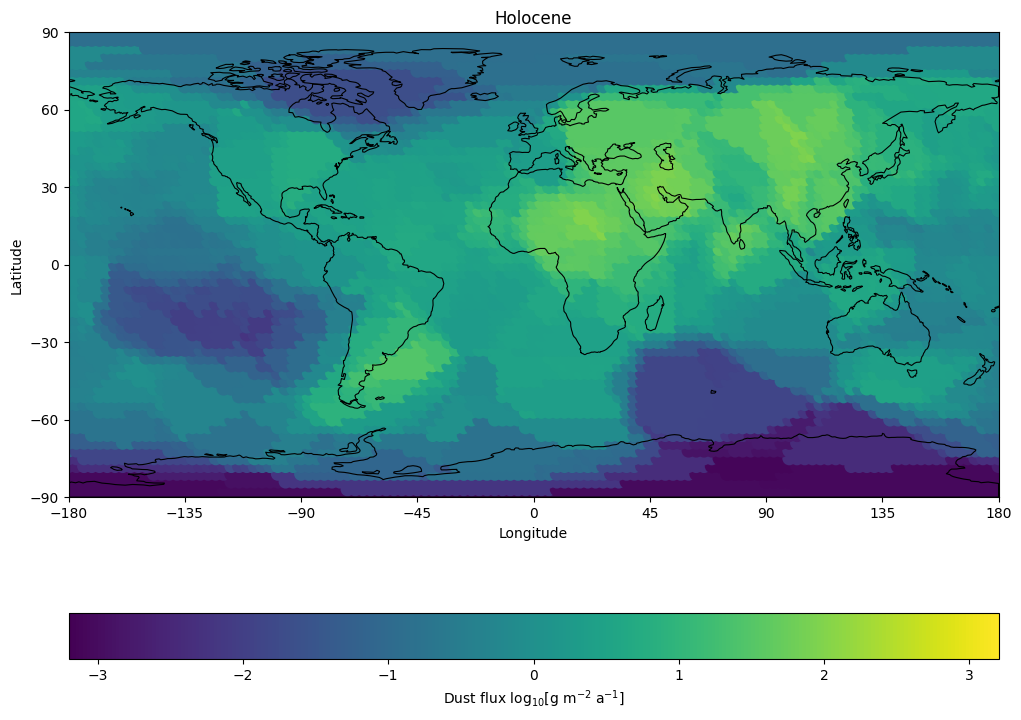

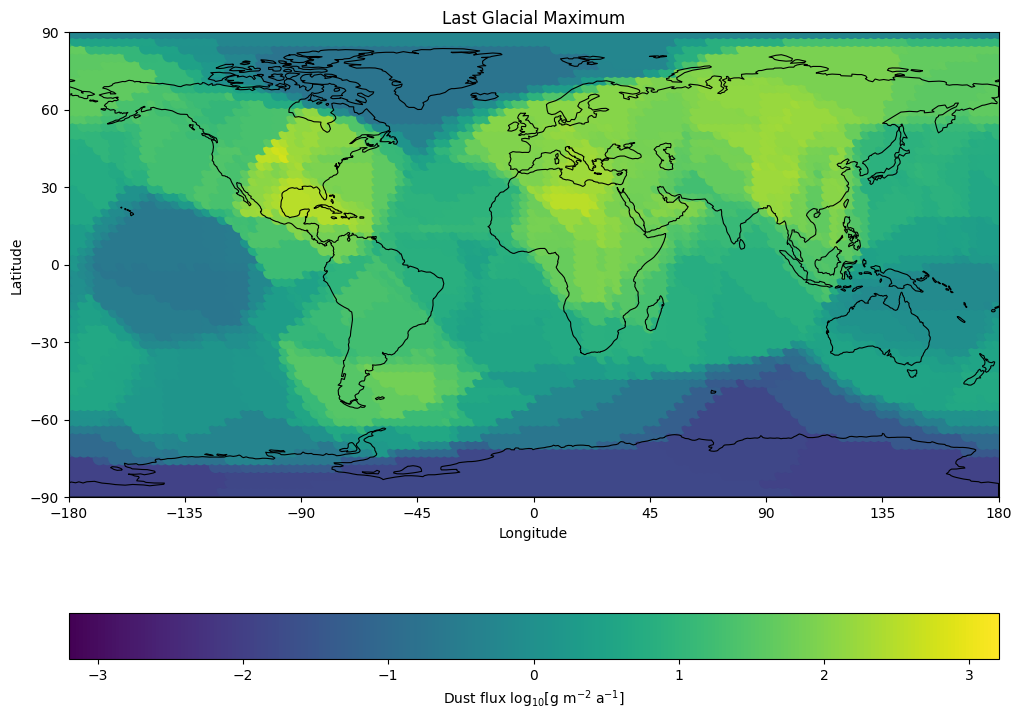

In [24]:
estimations_holocene_geo_buena = np.repeat(np.inf, len(df_global_grid))
estimations_lgm_geo_buena = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene_geo_buena[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='geodesic')
    estimations_lgm_geo_buena[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='geodesic')

df_global_grid["est_hol_geo_buena"] = estimations_holocene_geo_buena
df_global_grid["est_lgm_geo_buena"] = estimations_lgm_geo_buena

del estimations_holocene_geo_buena
del estimations_lgm_geo_buena


plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE',
                         label_str='est_hol_geo_buena')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM',
                         label_str='est_lgm_geo_buena')

Estos mapas son mucho mas esperables, especificamente, tiene el resultado deseable de que en los polos se tenga el mismo valor, lo cual no sucedia con la geodesica mala.

## 5: Diferencia entre Euclideana y Geodesica.

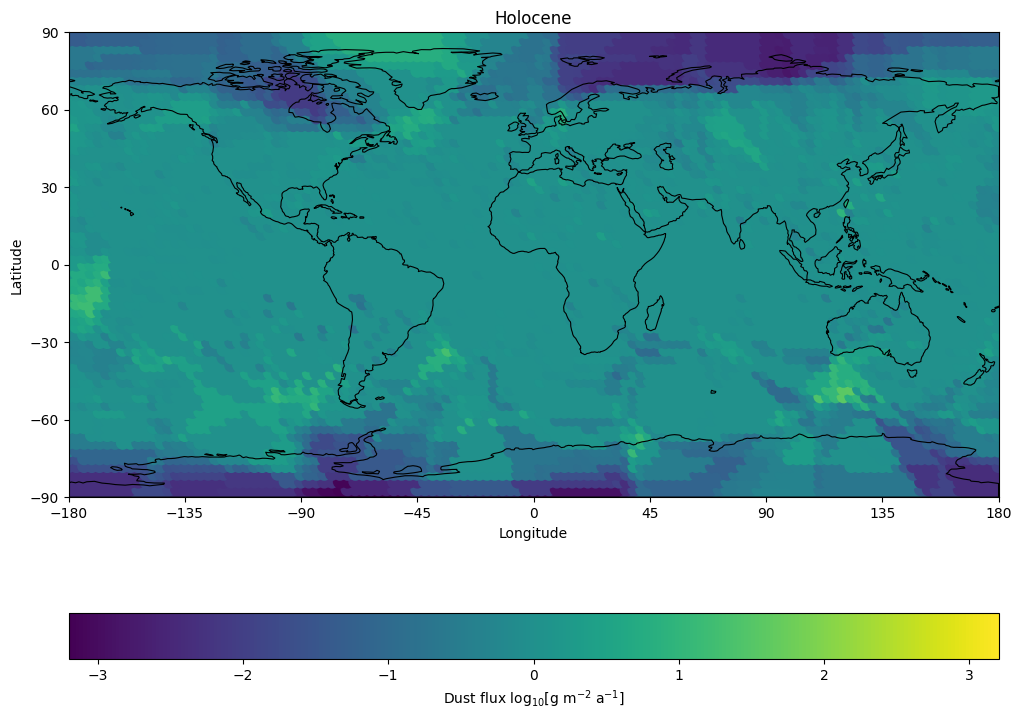

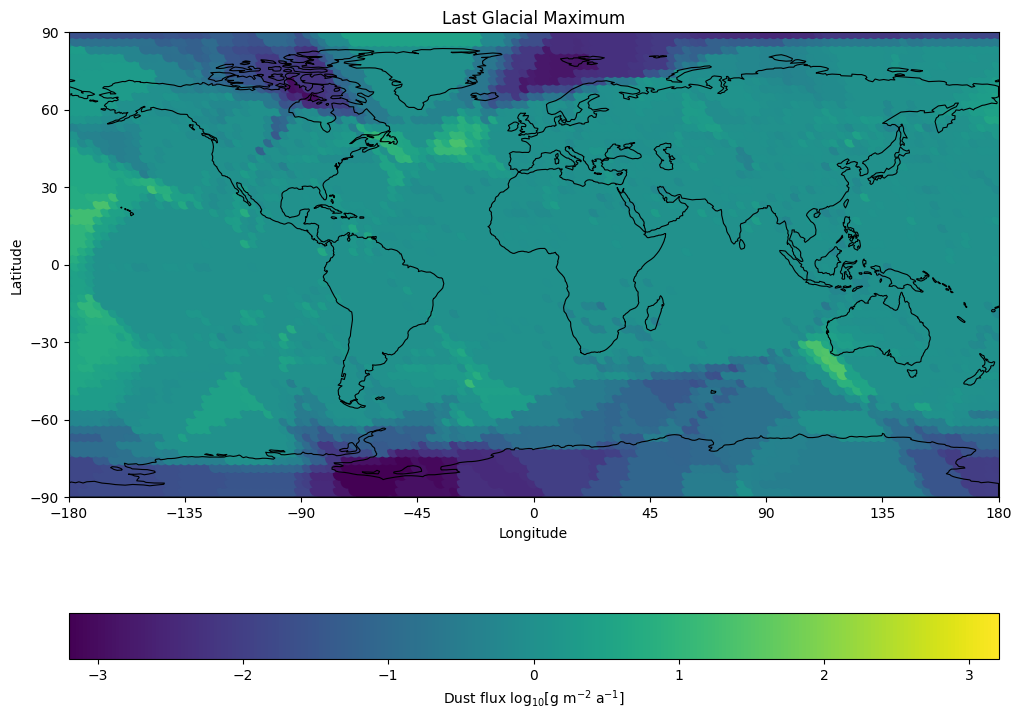

In [25]:
# Sabiendo que habria que hacer esto, reformule el codigo para que mantenga reservadas todas las diastancias, entonces obtener la diferencia se vuelve una tarea simple
# Que consiste en simplemente restar las dos columnas.

df_global_grid["dif_euclid_geo_hol"] = df_global_grid["est_hol_geo_buena"] - df_global_grid["est_hol_euclid"]
df_global_grid["dif_euclid_geo_lgm"] = df_global_grid["est_lgm_geo_buena"] - df_global_grid["est_lgm_euclid"]


plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE',
                         label_str='dif_euclid_geo_hol')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM',
                         label_str='dif_euclid_geo_lgm')

## 6 Discutir las diferencias:

### a) Por qué las diferencias son m ́as grandes en una parte que otra parte del mundo?
### b) ¿Cuál método es más fidedigno en los polos sur y norte?
### c) ¿Cuál método es más fidedigno en longitud 180°?

Debido a que la distancia euclideana no tiene en cuenta la forma de la tierra, al asumir que es como una hoja de papel, entonces suceden situaciones donde el oceano pacifico por el lado asiatico y americano pueden tener resultados distintos provenientes de que no se tome en cuenta su verdadera cercania. Pasa lo mismo en los polos, el polo norte y sur, son un solo punto cada uno, pero la distancia euclideana los interpreta como si fueran una linea entera.

En cambio la distancia Geodesica (la Buena, sin mezclar latitud con longitud), arregla estos problemas, al tomar la distancia de un gran arco de circulo en la tierra, En palabras mas simples, si caminaras en la linea recta mas corta entre los dos puntos, en la tierra, ¿Cual seria la distancia?

Es por esta razon que la distancia Geodesica es mas fidedigna a la realidad en las longitudes de +-180°, y las latitudes de +-90°

### d) Diferencias holoceno: Gracias a el trabajo previo, simplemente tomamos la diferencia entre el holoceno y el LGM

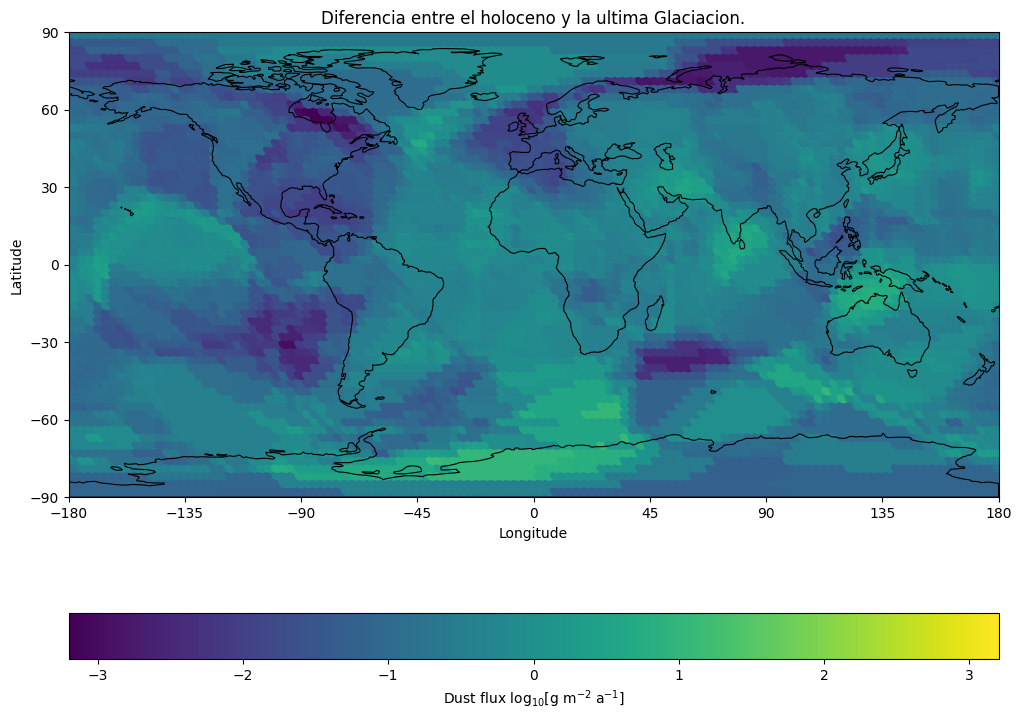

In [29]:
df_global_grid["dif_hol_lgm"] = df_global_grid["est_hol_geo_buena"] - df_global_grid["est_lgm_geo_buena"]


plot_dust_deposition_map(df=df_global_grid,
                         title='Diferencia entre el holoceno y la ultima Glaciacion.',
                         name_to_save='ESTIMATION_MAP_HOLOCENE',
                         label_str='dif_hol_lgm')

No se muy bien la diferencia, solo pienso en que la diferencia entre el holoceno y la glaciacion esta en los lugares con mas hielo, es decir, el norte de Europa y America del Norte, en el cual se nota una diferencia que indicaria que "Dust flux" era mayor en la era de la glaciacion, al menos en las zonas del norte.

Aun asi no podria dar una respuesta apropiada, ademas, existe otro problema, no hay informacion perfecta, pues en realidad este mapa esta hecho de tomar los puntos mas cercanos como la realidad, por ejemplo noto que este metodo falla en la cuenca del Missisippi en estados unidos, donde en el holoceno se ven varios puntos amarillos pero en el LGM no hay informacion disponible.

Otro problema seria si tuve una mala interpretacion del enunciado, pero hasta donde yo se, simplemente tome la diferencia entre el holoceno y el LGM, y note que no hay mucha diferencia, claro eso si, usando la geodesica como medida de distancia.

### e) ¿Cómo elegir el número de vecinos cercanos?

No esta muy dentro de los contenidos del curso, si no que es algo que se vio en un curso que yo al menos tome anteriormente, IMT2200, Introduccion a la Ciencia de Datos, el cual explico ciertas metricas para medir la eficiencia de estas aproximaciones, en si lo ideal seria tener un conjunto de elementos de prueba, con los cuales poder determinar si nuestra prediccion por KNN es cercana a la realidad.

En si, creo que una medida que se usa, es el metodo del codo, que se usa con mas cosas ademas del Nearest Neighbors, pero por ejemplo, yo y mi grupo lo usamos en nuestro proyecto en ese curso anterior para hacer un clustering de usuarios en un sitio de anime, y viendo en donde habia un cambio de pendiente, entonces elegir ese punto como la cantidad de clusters, o de vecinos cercanos en este caso.

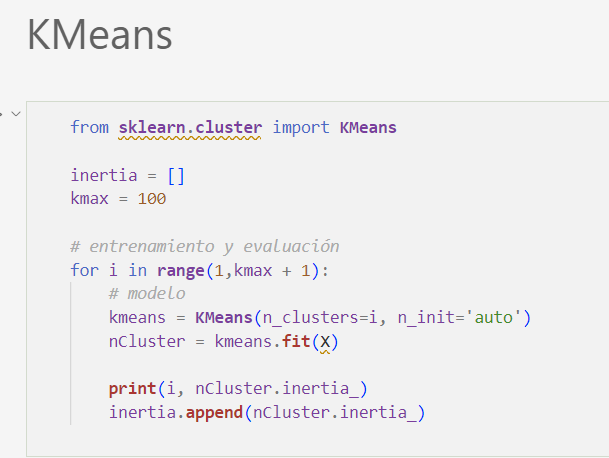

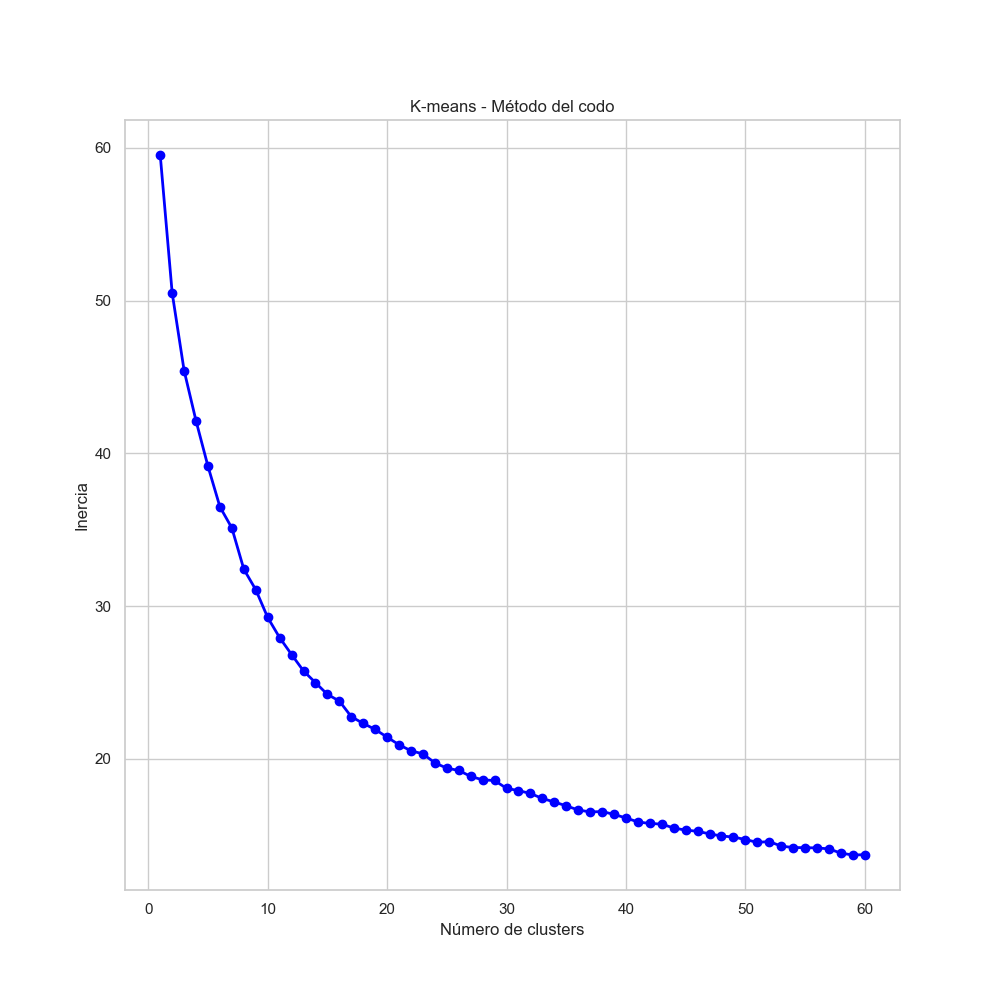

Esas son imagenes de nuestro proyecto, mostrando el uso de los KNN para clustering, en ese caso elegimos 20 clusters.

Hay que tomar en cuenta que para este caso hay que basarse en otra metrica, pero me imagino que la metodologia seria similar, tomar una medida de eficiencia, y detenerse cuando los beneficios se ralentizen, *Diminishing returns* en ingles.

## **Ultimos comentarios**

Aunque no me daban muchas ganas, por conveniencia modifique el codigo, creo que esta tarea fue hecha apuradamente (por los creadores) pues el codigo lo encuentro sub-optimo, usando mucho las for loops, siendo que deberian usarse metodos nativos de pandas o de numpy como apply.

Pero es precisamente debido a eso que lo modifique un poco para guardar cada uno de los resultados en el dataframe, de esa manera, no tengo que hacer todo de nuevo, en mi caso, en ejecutar todo se tardaria menos de 12 minutos, lo cual podria haber sido peor.